In [353]:
using PyCall
using Statistics
using LinearAlgebra
using Random
using Distributions
using TensorCrossInterpolation
import TensorCrossInterpolation as TCI
using JLD2
using Tensor_FixedSeedMC
import Tensor_FixedSeedMC as TCIMC

np = pyimport("numpy")
@pyimport tf_quant_finance as tff
@pyimport tensorflow as tf

In [354]:
nPath = 10

10

In [355]:
JLD2.@load "../make_tt/tt_tci_$nPath" tt_tci

1-element Vector{Symbol}:
 :tt_tci

In [356]:
function chebyshev_lobatto_nodes(n::Int, a::Real, b::Real)
    # [-1,1] のチェビシェフ-ロバット節点 → [a,b] へ写像
    x_standard = [cos(π * (n - 1 - i) / (n - 1)) for i in 0:n-1]
    x_scaled = 0.5 * (b - a) .* (x_standard .+ 1) .+ a
    return x_scaled, x_standard
end

function calculate_option_price(
    T::Float64, r::Float64, K::Float64, d::Int, stock0::Vector{Float64},
    localindex_v::Vector{Int}, nPath::Int, σs::Vector{Float64}, corrMat
)::Tuple{Float64, Float64}
    # ボラリティ、初期株価の組み合わせを抽出
    # s0_vals  = [S0_values_equiv[localindex_v[2i-1]] for i in 1:d]
    # vol_vals = [implied_vol_values_equiv[localindex_v[2i]] for i in 1:d]
    vols = [σs[i] for i in localindex_v[1:2:2*d]]
    S0s = [stock0[i] for i in localindex_v[2:2:2*d]]

    np.random.seed(seed)  # numpyのシードを固定
    tf.random.set_seed(seed)  # tensorflowのシードを固定
    
    process = tff.models.MultivariateGeometricBrownianMotion(
        dim=d,
        means=fill(r, d),
        volatilities=vols,
        corr_matrix=corrMat)
    
    paths = process.sample_paths(
        times=[T],
        initial_state=S0s,
        random_type=tff.math.random.RandomType.PSEUDO,
        seed = seed,
        num_samples=nPath
    ).numpy()
    
    payoffs = max.(minimum(paths[:, 1, :], dims=2) .- K, 0.0)
    mean_pv = exp(-r * T) * mean(payoffs)
    std_pv = exp(-r * T) * std(payoffs)
    return (mean_pv, std_pv)
end


calculate_option_price (generic function with 1 method)

In [357]:
# 満期・金利・行使価格など
T = 1.0               # 満期
r = 0.01              # 無リスク金利
K = 100.0             # 行使価格
d = 5                 # 原資産数
seed = 1234

num_nodes = 100
σs, _ = chebyshev_lobatto_nodes(num_nodes, 0.15, 0.25)    # ボラティリティグリッド
stock0, _ = chebyshev_lobatto_nodes(num_nodes, 90, 120)   # 初期株価グリッド

corrMat = [
    1.0      0.303659  0.505532  0.719655  0.728832;
    0.303659 1.0      0.401077  0.515272  0.178203;
    0.505532 0.401077 1.0      0.132542  0.722767;
    0.719655 0.515272 0.132542 1.0      0.394723;
    0.728832 0.178203 0.722767 0.394723  1.0
]

5×5 Matrix{Float64}:
 1.0       0.303659  0.505532  0.719655  0.728832
 0.303659  1.0       0.401077  0.515272  0.178203
 0.505532  0.401077  1.0       0.132542  0.722767
 0.719655  0.515272  0.132542  1.0       0.394723
 0.728832  0.178203  0.722767  0.394723  1.0

In [358]:
M_dct = TCIMC.dct_matrix(num_nodes)
C_coeff_tensor_tci = TCIMC.compute_chebyshev_coeff(TCI.TensorTrain(tt_tci), fill(M_dct, 2d))

(::TensorTrain{Float64, 3}) (generic function with 1 method)

In [359]:
using Statistics, Random

#num_nodes = n
num_nodes_S0 = 300
S0_values_equiv = collect(range(90.0, stop=120.0, length=num_nodes_S0))
implied_vol_values_equiv = collect(range(0.15, stop=0.25, length=num_nodes))

# 全インデックスの組を作成して、ランダムに100点抽出
Random.seed!(1234)
n_samples = 100 
localindex_v_list = [
    [(i % 2 == 1) ? rand(1:num_nodes) : rand(1:num_nodes_S0) for i in 1:2d]
    for _ in 1:n_samples
]

100-element Vector{Vector{Int64}}:
 [33, 165, 22, 269, 36, 119, 96, 239, 50, 225]
 [58, 219, 1, 60, 44, 205, 96, 195, 100, 225]
 [12, 148, 57, 77, 63, 71, 13, 183, 68, 229]
 [59, 110, 14, 284, 58, 204, 58, 22, 71, 29]
 [85, 105, 77, 81, 54, 89, 25, 294, 86, 212]
 [45, 266, 53, 283, 82, 140, 98, 151, 72, 57]
 [38, 170, 18, 99, 64, 113, 73, 1, 14, 160]
 [8, 151, 91, 36, 37, 265, 68, 144, 95, 8]
 [35, 246, 80, 291, 48, 59, 95, 201, 90, 108]
 [73, 121, 32, 242, 11, 150, 56, 147, 50, 280]
 ⋮
 [99, 82, 94, 193, 3, 105, 64, 132, 43, 271]
 [15, 106, 94, 184, 68, 80, 28, 180, 17, 109]
 [36, 38, 3, 140, 62, 284, 46, 277, 78, 164]
 [18, 287, 73, 100, 48, 9, 12, 289, 18, 134]
 [23, 296, 94, 255, 63, 259, 33, 156, 80, 261]
 [37, 227, 96, 14, 39, 293, 89, 73, 62, 97]
 [3, 70, 54, 194, 36, 148, 19, 4, 84, 75]
 [89, 126, 98, 26, 4, 118, 96, 144, 67, 290]
 [2, 123, 53, 278, 44, 236, 79, 33, 19, 279]

In [360]:
Random.seed!(seed)
d = 5  # 資産数、必要に応じて変更
price_dict_tci = Dict{NTuple{2d,Int}, Float64}()

Random.seed!(1234)
for localindex_v in localindex_v_list
    # [S0_1, σ1, S0_2, σ2, ..., S0_d, σd] のインデックスをランダム生成

    # 各資産ごとに値を取得
    vol_vals = [implied_vol_values_equiv[localindex_v[2i-1]] for i in 1:d]
    s0_vals  = [S0_values_equiv[localindex_v[2i]] for i in 1:d]

    # Chebyshev基底を作成（下記区間は必要に応じてパラメータ化可能）
    weights = Vector{Vector{Float64}}()
    for j in 1:d
        push!(weights, TCIMC.chebyshev_basis(0.15, 0.25, vol_vals[j], num_nodes))   # σj
        push!(weights, TCIMC.chebyshev_basis(90.0, 120.0, s0_vals[j], num_nodes)) # S0_j
    end
    # これでweightsは [σ1, S0_1, σ2, S0_2, ..., σ5, S0_5] の順

    c = 1
    left_cache  = TCIMC.compute_left_cache(C_coeff_tensor_tci, weights, c)
    right_cache = TCIMC.compute_right_cache(C_coeff_tensor_tci, weights, c)
    result_original = TCIMC.update_center(C_coeff_tensor_tci, left_cache, right_cache, weights[c], c)

    price_dict_tci[Tuple(localindex_v)] = result_original
end


In [361]:
# -----------------------------------
# MC による価格評価
# -----------------------------------

price_dict_mc = Dict{NTuple{2d, Int}, Float64}()
price_dict_mc_err = Dict{NTuple{2d, Int}, Float64}()

for localindex_v in localindex_v_list
    mean_pv, std_pv = calculate_option_price(T, r, K, d, S0_values_equiv , localindex_v, nPath, implied_vol_values_equiv, corrMat)
    price_dict_mc[Tuple(localindex_v)] = mean_pv
    price_dict_mc_err[Tuple(localindex_v)] = std_pv
end


In [362]:
JLD2.@save "err_price/price_dict_tci" price_dict_tci
JLD2.@save "err_price/price_dict_mc" price_dict_mc
JLD2.@save "err_price/price_dict_mc_err" price_dict_mc_err

In [363]:
using Statistics

# 辞書の型を修正
abs_errors_tci = Dict{NTuple{2d,Int},Float64}()
rel_errors_tci = Dict{NTuple{2d,Int},Float64}()
mc_errors      = Dict{NTuple{2d,Int},Float64}()

for key in keys(price_dict_mc)
    # Monte Carlo の結果 (price_dict_mc[key]) と TCI の結果 (price_dict_tci[key]) の差を評価
    mc_val = price_dict_mc[key]
    tci_val = price_dict_tci[key]

    abs_err = abs(mc_val - tci_val)
    rel_err = abs_err / (abs(mc_val) + 1e-12)  # 0除算回避

    abs_errors_tci[key] = abs_err
    rel_errors_tci[key] = rel_err
    mc_errors[key] = price_dict_mc_err[key]
end

# 統計量を計算
abs_error_vals = collect(values(abs_errors_tci))
mc_error_vals  = collect(values(mc_errors))

println("==== TCI  ====")
println("Mean absolute error   : ", mean(abs_error_vals))
println("Max  absolute error   : ", maximum(abs_error_vals))

println("==== MC  ====")
println("Mean MC error         : ", mean(mc_error_vals))
println("Max  MC error         : ", maximum(mc_error_vals))


==== TCI  ====
Mean absolute error   : 0.6651814317462881
Max  absolute error   : 1.9018431545703043
==== MC  ====
Mean MC error         : 3.396062939186338
Max  MC error         : 7.6037378233222706


# \sigma 依存性

In [364]:
num_nodes = length(implied_vol_values_equiv)
num_nodes_S0 = length(S0_values_equiv)
d = 5

# σ1だけスイープ、他は固定
fixed_indices = [
    rand(1:num_nodes_S0),  # S0_1
    rand(1:num_nodes),     # σ2
    rand(1:num_nodes_S0),  # S0_2
    rand(1:num_nodes),     # σ3
    rand(1:num_nodes_S0),  # S0_3
    rand(1:num_nodes),     # σ4
    rand(1:num_nodes_S0),  # S0_4
    rand(1:num_nodes),     # σ5
    rand(1:num_nodes_S0)   # S0_5
]
# [S0_1, σ2, S0_2, σ3, ..., σ5, S0_5]の並び（σ1だけあとで入れる）

xvals = Float64[]
tci_vals = Float64[]
mc_vals      = Float64[]
mc_errs      = Float64[]

for i in 1:num_nodes
    # localindex_vを [σ1, S0_1, σ2, S0_2, ...] の順で作る
    localindex_v = [i; fixed_indices...]
    # [σ1, S0_1, σ2, S0_2, ..., σ5, S0_5] の順

    # 各資産の値取得
    vol_vals = [implied_vol_values_equiv[localindex_v[2j-1]] for j in 1:d]
    s0_vals  = [S0_values_equiv[localindex_v[2j]] for j in 1:d]

    # weightsも [σ1, S0_1, σ2, S0_2, ..., σ5, S0_5] の順で
    weights = Vector{Vector{Float64}}()
    for j in 1:d
        push!(weights, TCIMC.chebyshev_basis(0.15, 0.25, vol_vals[j], num_nodes))
        push!(weights, TCIMC.chebyshev_basis(90.0, 120.0, s0_vals[j], num_nodes))
    end

    c = 1
    left_cache  = TCIMC.compute_left_cache(C_coeff_tensor_tci, weights, c)
    right_cache = TCIMC.compute_right_cache(C_coeff_tensor_tci, weights, c)
    price = TCIMC.update_center(C_coeff_tensor_tci, left_cache, right_cache, weights[c], c)

    #push!(xvals, implied_vol_values_equiv[i])  # x軸はσ1
    push!(tci_vals, price)

        # --- MCによる価格 ---
    mean_mc, std_mc = calculate_option_price(
        T, r, K, d, S0_values_equiv, localindex_v, nPath, implied_vol_values_equiv, corrMat
    )
    push!(mc_vals, mean_mc)
    push!(mc_errs, std_mc / sqrt(nPath))

    # x軸（σ1の値）
    push!(xvals, implied_vol_values_equiv[localindex_v[1]])
end


In [365]:
# σ1だけスイープ、他は固定
fixed_indices = [
    rand(1:num_nodes_S0),  # S0_1
    rand(1:num_nodes),     # σ2
    rand(1:num_nodes_S0),  # S0_2
    rand(1:num_nodes),     # σ3
    rand(1:num_nodes_S0),  # S0_3
    rand(1:num_nodes),     # σ4
    rand(1:num_nodes_S0),  # S0_4
    rand(1:num_nodes),     # σ5
    rand(1:num_nodes_S0)   # S0_5
]

# インデックスから値へ
fixed_vals = [
    S0_values_equiv[fixed_indices[1]],     # S0_1
    implied_vol_values_equiv[fixed_indices[2]], # σ2
    S0_values_equiv[fixed_indices[3]],     # S0_2
    implied_vol_values_equiv[fixed_indices[4]], # σ3
    S0_values_equiv[fixed_indices[5]],     # S0_3
    implied_vol_values_equiv[fixed_indices[6]], # σ4
    S0_values_equiv[fixed_indices[7]],     # S0_4
    implied_vol_values_equiv[fixed_indices[8]], # σ5
    S0_values_equiv[fixed_indices[9]]      # S0_5
]


9-element Vector{Float64}:
 112.47491638795987
   0.20757575757575758
 111.87290969899665
   0.15
  95.91973244147157
   0.19343434343434343
 110.46822742474916
   0.24595959595959596
 109.4648829431438

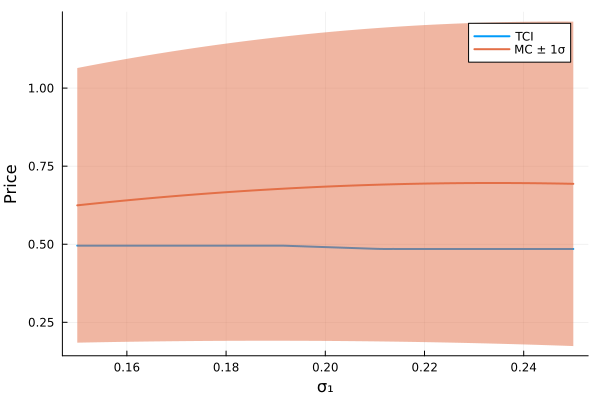

In [366]:
# プロット
using Plots
plot(xvals, tci_vals, label="TCI", xlabel="σ₁", ylabel="Price", lw=2)
plot!(xvals, mc_vals, ribbon=mc_errs, label="MC ± 1σ", lw=2)

## S0が小さい値のプロット

In [367]:
num_nodes = length(implied_vol_values_equiv)
num_nodes_S0 = length(S0_values_equiv)
d = 5

# σ1だけスイープ、他は固定
fixed_indices = [
    1,  # S0_1
    rand(1:num_nodes),     # σ2
    1,  # S0_2
    rand(1:num_nodes),     # σ3
    1,  # S0_3
    rand(1:num_nodes),     # σ4
    1,  # S0_4
    rand(1:num_nodes),     # σ5
    1   # S0_5
]
# [S0_1, σ2, S0_2, σ3, ..., σ5, S0_5]の並び（σ1だけあとで入れる）

xvals = Float64[]
tci_vals = Float64[]
mc_vals      = Float64[]
mc_errs      = Float64[]

for i in 1:num_nodes
    # localindex_vを [σ1, S0_1, σ2, S0_2, ...] の順で作る
    localindex_v = [i; fixed_indices...]
    # [σ1, S0_1, σ2, S0_2, ..., σ5, S0_5] の順

    # 各資産の値取得
    vol_vals = [implied_vol_values_equiv[localindex_v[2j-1]] for j in 1:d]
    s0_vals  = [S0_values_equiv[localindex_v[2j]] for j in 1:d]

    # weightsも [σ1, S0_1, σ2, S0_2, ..., σ5, S0_5] の順で
    weights = Vector{Vector{Float64}}()
    for j in 1:d
        push!(weights, TCIMC.chebyshev_basis(0.15, 0.25, vol_vals[j], num_nodes))
        push!(weights, TCIMC.chebyshev_basis(90.0, 120.0, s0_vals[j], num_nodes))
    end

    c = 1
    left_cache  = TCIMC.compute_left_cache(C_coeff_tensor_tci, weights, c)
    right_cache = TCIMC.compute_right_cache(C_coeff_tensor_tci, weights, c)
    price = TCIMC.update_center(C_coeff_tensor_tci, left_cache, right_cache, weights[c], c)

    #push!(xvals, implied_vol_values_equiv[i])  # x軸はσ1
    push!(tci_vals, price)

        # --- MCによる価格 ---
    mean_mc, std_mc = calculate_option_price(
        T, r, K, d, S0_values_equiv, localindex_v, nPath, implied_vol_values_equiv, corrMat
    )
    push!(mc_vals, mean_mc)
    push!(mc_errs, std_mc / sqrt(nPath))

    # x軸（σ1の値）
    push!(xvals, implied_vol_values_equiv[localindex_v[1]])
end


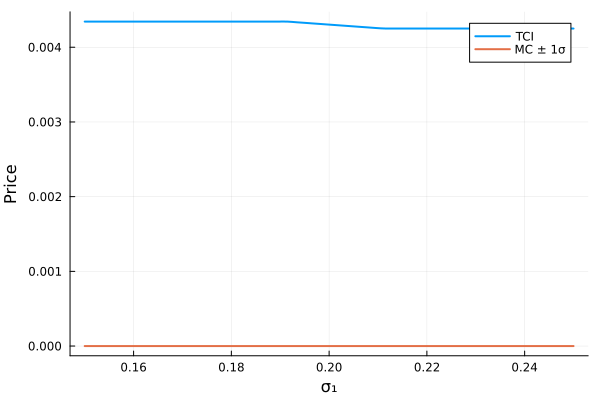

In [368]:
# プロット
using Plots
plot(xvals, tci_vals, label="TCI", xlabel="σ₁", ylabel="Price", lw=2)
plot!(xvals, mc_vals, ribbon=mc_errs, label="MC ± 1σ", lw=2)

# S0が大きい

In [369]:
num_nodes = length(implied_vol_values_equiv)
num_nodes_S0 = length(S0_values_equiv)
d = 5

# σ1だけスイープ、他は固定
fixed_indices = [
    300,  # S0_1
    rand(1:num_nodes),     # σ2
    300,  # S0_2
    rand(1:num_nodes),     # σ3
    300,  # S0_3
    rand(1:num_nodes),     # σ4
    300,  # S0_4
    rand(1:num_nodes),     # σ5
    300   # S0_5
]
# [S0_1, σ2, S0_2, σ3, ..., σ5, S0_5]の並び（σ1だけあとで入れる）

xvals = Float64[]
tci_vals = Float64[]
mc_vals      = Float64[]
mc_errs      = Float64[]

for i in 1:num_nodes
    # localindex_vを [σ1, S0_1, σ2, S0_2, ...] の順で作る
    localindex_v = [i; fixed_indices...]
    # [σ1, S0_1, σ2, S0_2, ..., σ5, S0_5] の順

    # 各資産の値取得
    vol_vals = [implied_vol_values_equiv[localindex_v[2j-1]] for j in 1:d]
    s0_vals  = [S0_values_equiv[localindex_v[2j]] for j in 1:d]

    # weightsも [σ1, S0_1, σ2, S0_2, ..., σ5, S0_5] の順で
    weights = Vector{Vector{Float64}}()
    for j in 1:d
        push!(weights, TCIMC.chebyshev_basis(0.15, 0.25, vol_vals[j], num_nodes))
        push!(weights, TCIMC.chebyshev_basis(90.0, 120.0, s0_vals[j], num_nodes))
    end

    c = 1
    left_cache  = TCIMC.compute_left_cache(C_coeff_tensor_tci, weights, c)
    right_cache = TCIMC.compute_right_cache(C_coeff_tensor_tci, weights, c)
    price = TCIMC.update_center(C_coeff_tensor_tci, left_cache, right_cache, weights[c], c)

    #push!(xvals, implied_vol_values_equiv[i])  # x軸はσ1
    push!(tci_vals, price)

        # --- MCによる価格 ---
    mean_mc, std_mc = calculate_option_price(
        T, r, K, d, S0_values_equiv, localindex_v, nPath, implied_vol_values_equiv, corrMat
    )
    push!(mc_vals, mean_mc)
    push!(mc_errs, std_mc / sqrt(nPath))

    # x軸（σ1の値）
    push!(xvals, implied_vol_values_equiv[localindex_v[1]])
end


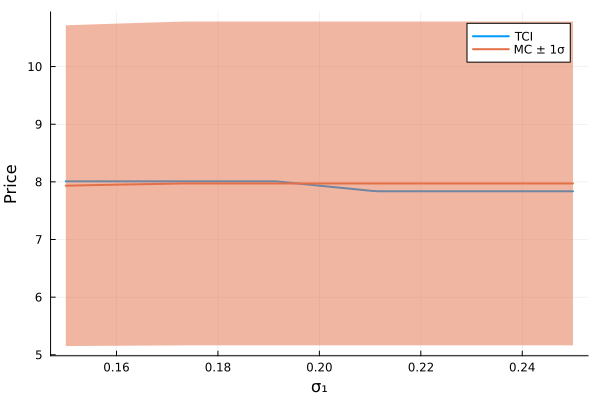

In [370]:
# プロット
using Plots
plot(xvals, tci_vals, label="TCI", xlabel="σ₁", ylabel="Price", lw=2)
plot!(xvals, mc_vals, ribbon=mc_errs, label="MC ± 1σ", lw=2)

# S0_1依存性

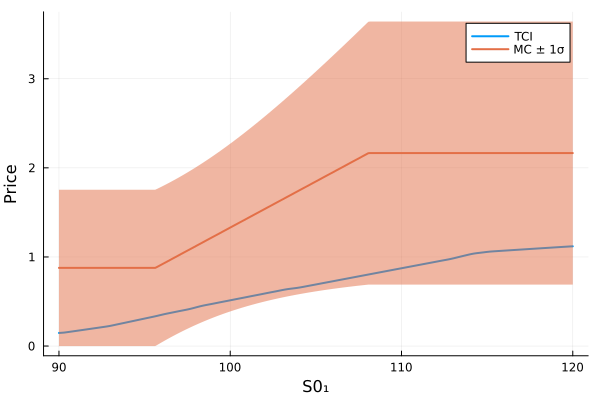

In [371]:
# S0_1だけスイープ、他は固定
fixed_indices = [
    rand(1:num_nodes),     # σ1
    # ---- ここからS0_1, σ2, S0_2, σ3 ...の順で交互に並ぶ ----
    # S0_1はスイープするのでここは空けておく
    rand(1:num_nodes),     # σ2
    rand(1:num_nodes_S0),  # S0_2
    rand(1:num_nodes),     # σ3
    rand(1:num_nodes_S0),  # S0_3
    rand(1:num_nodes),     # σ4
    rand(1:num_nodes_S0),  # S0_4
    rand(1:num_nodes),     # σ5
    rand(1:num_nodes_S0)   # S0_5
]
# fixed_indices[1] = σ1
# fixed_indices[2:end] = σ2, S0_2, σ3, S0_3, ..., σ5, S0_5

xvals    = Float64[]
tci_vals = Float64[]
mc_vals  = Float64[]
mc_errs  = Float64[]

for i in 1:num_nodes_S0
    # localindex_vを [σ1, S0_1, σ2, S0_2, ...] の順で作る
    localindex_v = [fixed_indices[1]; i; fixed_indices[2:end]...]
    # [σ1, S0_1, σ2, S0_2, ..., σ5, S0_5] の順

    # 各資産の値取得
    vol_vals = [implied_vol_values_equiv[localindex_v[2j-1]] for j in 1:d]
    s0_vals  = [S0_values_equiv[localindex_v[2j]] for j in 1:d]

    # weights
    weights = Vector{Vector{Float64}}()
    for j in 1:d
        push!(weights, TCIMC.chebyshev_basis(0.15, 0.25, vol_vals[j], num_nodes))
        push!(weights, TCIMC.chebyshev_basis(90.0, 120.0, s0_vals[j], num_nodes))
    end

    c = 1
    left_cache  = TCIMC.compute_left_cache(C_coeff_tensor_tci, weights, c)
    right_cache = TCIMC.compute_right_cache(C_coeff_tensor_tci, weights, c)
    price = TCIMC.update_center(C_coeff_tensor_tci, left_cache, right_cache, weights[c], c)

    push!(tci_vals, price)

    # --- MCによる価格 ---
    mean_mc, std_mc = calculate_option_price(
        T, r, K, d, S0_values_equiv, localindex_v, nPath, implied_vol_values_equiv, corrMat
    )
    push!(mc_vals, mean_mc)
    push!(mc_errs, std_mc / sqrt(nPath))

    # x軸（S0_1の値）
    push!(xvals, S0_values_equiv[i])
end

using Plots
plot(xvals, tci_vals, label="TCI", xlabel="S0₁", ylabel="Price", lw=2)
plot!(xvals, mc_vals, ribbon=mc_errs, label="MC ± 1σ", lw=2)


## Vega

In [372]:
## MCのvegaを計算するコード
function vega_MC(T::Float64, r::Float64, K::Float64, d::Int64,  stock0::Vector{Float64}, localindex_v::Vector{Int64}, nPath::Int64, σs::Vector{Float64}, corrMat, delta_vols)::Tuple{Float64, Float64}
    vols = [σs[i] for i in localindex_v[1:2:2*d]]
    S0s = [stock0[i] for i in localindex_v[2:2:2*d]]

    vols_minus = [vols[1] - delta_vols; vols[2:end]]  # Subtract delta_vols from the first element
    vols_plus = [vols[1] + delta_vols; vols[2:end]] 

    np.random.seed(seed)  # numpyのシードを固定
    tf.random.set_seed(seed)  # tensorflowのシードを固定

    process = tff.models.MultivariateGeometricBrownianMotion(
        dim=d,
        means=fill(r, d),
        #volatilities=fill(0.2, d),
        volatilities=vols_minus,
        corr_matrix=corrMat)
    paths_minus = process.sample_paths(
        times=[T],
        initial_state=S0s,
        #initial_state=S0,
        seed = seed,
        num_samples=nPath).numpy()

    np.random.seed(seed)  # numpyのシードを固定
    tf.random.set_seed(seed)  # tensorflowのシードを固定
    process = tff.models.MultivariateGeometricBrownianMotion(
        dim=d,
        means=fill(r, d),
        volatilities=vols_plus,
        corr_matrix=corrMat)
    
    paths_plus = process.sample_paths(
        times=[T],
        initial_state=S0s,
        seed = seed,
        num_samples=nPath).numpy()
    
    #diff = ((maximum(paths_plus[:, 1, :], dims=2) .- K, 0.0) .- (maximum(paths_minus[:, 1, :], dims=2) .- K, 0.0)) 
    #diff = (maximum(minimum(paths_plus[:, 1, :], dims=2) .- K, 0.0) .- maximum(minimum(paths_minus[:, 1, :], dims=2) .- K, 0.0))
    payoffs_plus = max.(minimum(paths_plus[:, 1, :], dims=2) .- K, 0.0)
    payoffs_minus = max.(minimum(paths_minus[:, 1, :], dims=2) .- K, 0.0)
    diff = payoffs_plus .- payoffs_minus
    mean_pv = exp(-r * T) * mean(diff) / (2 * delta_vols)
    std_pv = exp(-r * T) * std(diff) / (2 * delta_vols)
    CI = std_pv / sqrt(nPath)
    #pv = exp(-r * T) * mean(max.(minimum(paths[:, 1, :], dims=2) .- K, 0.0))
    return (mean_pv, CI)
    #return pv

end
## MCの微分の差がここに来る。
#num_nodes = n
h_delta    = S0_values_equiv[2]    - S0_values_equiv[1]
Δvol   = implied_vol_values_equiv[2] - implied_vol_values_equiv[1]

0.0010101010101010166

In [373]:
Random.seed!(seed)
d = 5  # 資産数、必要に応じて変更
price_dict_tci_vega = Dict{NTuple{2d,Int}, Float64}()

Random.seed!(1234)
for localindex_v in localindex_v_list
    # [S0_1, σ1, S0_2, σ2, ..., S0_d, σd] のインデックスをランダム生成

    # 各資産ごとに値を取得
    vol_vals = [implied_vol_values_equiv[localindex_v[2i-1]] for i in 1:d]
    s0_vals  = [S0_values_equiv[localindex_v[2i]] for i in 1:d]

    # Chebyshev基底を作成（下記区間は必要に応じてパラメータ化可能）
    weights = Vector{Vector{Float64}}()
    for j in 1:d
        if j == 1
            push!(weights, TCIMC.chebyshev_basis_derivative(0.15, 0.25, vol_vals[j], num_nodes))
            push!(weights, TCIMC.chebyshev_basis(90.0, 120.0, s0_vals[j], num_nodes))
        else
            push!(weights, TCIMC.chebyshev_basis(0.15, 0.25, vol_vals[j], num_nodes))
            push!(weights, TCIMC.chebyshev_basis(90.0, 120.0, s0_vals[j], num_nodes))
        end
    end
    # これでweightsは [σ1, S0_1, σ2, S0_2, ..., σ5, S0_5] の順

    c = 1
    left_cache  = TCIMC.compute_left_cache(C_coeff_tensor_tci, weights, c)
    right_cache = TCIMC.compute_right_cache(C_coeff_tensor_tci, weights, c)
    result_original = TCIMC.update_center(C_coeff_tensor_tci, left_cache, right_cache, weights[c], c)

    price_dict_tci_vega[Tuple(localindex_v)] = result_original
end


In [374]:
# -----------------------------------
# MC による価格評価
# -----------------------------------

price_dict_mc_vega = Dict{NTuple{2d, Int}, Float64}()
price_dict_mc_err_vega = Dict{NTuple{2d, Int}, Float64}()

for localindex_v in localindex_v_list
    mean_pv, std_pv = vega_MC(T, r, K, d, S0_values_equiv , localindex_v, nPath, implied_vol_values_equiv, corrMat, Δvol)
    price_dict_mc_vega[Tuple(localindex_v)] = mean_pv
    price_dict_mc_err_vega[Tuple(localindex_v)] = std_pv
end


In [375]:
JLD2.@save "err_vega/vega_dict_tci" price_dict_tci_vega
JLD2.@save "err_vega/vega_dict_mc" price_dict_mc_vega
JLD2.@save "err_vega/vega_dict_mc_err" price_dict_mc_err_vega

In [376]:
using Statistics

# 辞書の型を修正
abs_errors_tci = Dict{NTuple{2d,Int},Float64}()
rel_errors_tci = Dict{NTuple{2d,Int},Float64}()
mc_errors      = Dict{NTuple{2d,Int},Float64}()

for key in keys(price_dict_mc_vega)
    # Monte Carlo の結果 (price_dict_mc[key]) と TCI の結果 (price_dict_tci[key]) の差を評価
    mc_val = price_dict_mc_vega[key]
    tci_val = price_dict_tci_vega[key]

    abs_err = abs(mc_val - tci_val)
    rel_err = abs_err / (abs(mc_val) + 1e-12)  # 0除算回避

    abs_errors_tci[key] = abs_err
    rel_errors_tci[key] = rel_err
    mc_errors[key] = price_dict_mc_err_vega[key]
end

# 統計量を計算
abs_error_vals = collect(values(abs_errors_tci))
mc_error_vals  = collect(values(mc_errors))

println("==== TCI  ====")
println("Mean absolute error   : ", mean(abs_error_vals))
println("Max  absolute error   : ", maximum(abs_error_vals))

println("==== MC  ====")
println("Mean MC error         : ", mean(mc_error_vals))
println("Max  MC error         : ", maximum(mc_error_vals))


==== TCI  ====
Mean absolute error   : 0.7129057869616744
Max  absolute error   : 15.131489971767932
==== MC  ====
Mean MC error         : 0.4794714606969157
Max  MC error         : 15.115833690821765


In [377]:
num_nodes = length(implied_vol_values_equiv)
num_nodes_S0 = length(S0_values_equiv)

# σ1だけスイープ、他は固定
fixed_indices = [
    1,  # S0_1
    rand(1:num_nodes),     # σ2
    1,  # S0_2
    rand(1:num_nodes),     # σ3
    1,  # S0_3
    rand(1:num_nodes),     # σ4
    1,  # S0_4
    rand(1:num_nodes),     # σ5
    1   # S0_5
]
# [S0_1, σ2, S0_2, σ3, ..., σ5, S0_5]の並び（σ1だけあとで入れる）

xvals = Float64[]
tci_vals = Float64[]
mc_vals      = Float64[]
mc_errs      = Float64[]

for i in 1:num_nodes
    # localindex_vを [σ1, S0_1, σ2, S0_2, ...] の順で作る
    localindex_v = [i; fixed_indices...]
    # [σ1, S0_1, σ2, S0_2, ..., σ5, S0_5] の順

    # 各資産の値取得
    vol_vals = [implied_vol_values_equiv[localindex_v[2j-1]] for j in 1:d]
    s0_vals  = [S0_values_equiv[localindex_v[2j]] for j in 1:d]

    # weightsも [σ1, S0_1, σ2, S0_2, ..., σ5, S0_5] の順で
    weights = Vector{Vector{Float64}}()
    for j in 1:d
        if j == 1
            push!(weights, TCIMC.chebyshev_basis_derivative(0.15, 0.25, vol_vals[j], num_nodes))
            push!(weights, TCIMC.chebyshev_basis(90.0, 120.0, s0_vals[j], num_nodes))
        else
            push!(weights, TCIMC.chebyshev_basis(0.15, 0.25, vol_vals[j], num_nodes))
            push!(weights, TCIMC.chebyshev_basis(90.0, 120.0, s0_vals[j], num_nodes))
        end
    end

    c = 1
    left_cache  = TCIMC.compute_left_cache(C_coeff_tensor_tci, weights, c)
    right_cache = TCIMC.compute_right_cache(C_coeff_tensor_tci, weights, c)
    price = TCIMC.update_center(C_coeff_tensor_tci, left_cache, right_cache, weights[c], c)

    #push!(xvals, implied_vol_values_equiv[i])  # x軸はσ1
    push!(tci_vals, price)

        # --- MCによる価格 ---
    mean_mc, std_mc = vega_MC(T, r, K, d, S0_values_equiv , localindex_v, nPath, implied_vol_values_equiv, corrMat, Δvol)
    push!(mc_vals, mean_mc)
    push!(mc_errs, std_mc)

    # x軸（σ1の値）
    push!(xvals, implied_vol_values_equiv[localindex_v[1]])
end

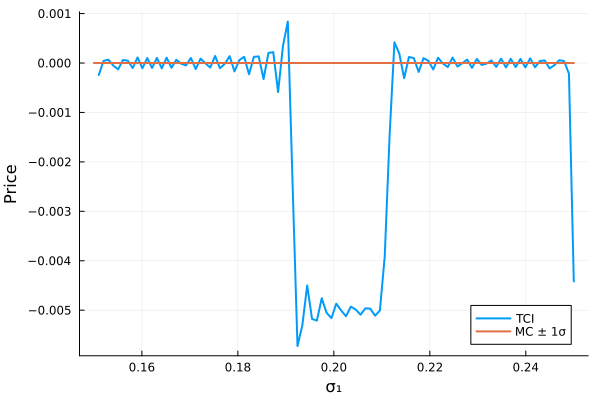

In [378]:
# プロット
using Plots
plot(xvals, tci_vals, label="TCI", xlabel="σ₁", ylabel="Price", lw=2)
plot!(xvals, mc_vals, ribbon=mc_errs, label="MC ± 1σ", lw=2)

In [379]:
num_nodes = length(implied_vol_values_equiv)
num_nodes_S0 = length(S0_values_equiv)

# σ1だけスイープ、他は固定
fixed_indices = [
    300,  # S0_1
    rand(1:num_nodes),     # σ2
    300,  # S0_2
    rand(1:num_nodes),     # σ3
    300,  # S0_3
    rand(1:num_nodes),     # σ4
    300,  # S0_4
    rand(1:num_nodes),     # σ5
    300   # S0_5
]
# [S0_1, σ2, S0_2, σ3, ..., σ5, S0_5]の並び（σ1だけあとで入れる）

xvals = Float64[]
tci_vals = Float64[]
mc_vals      = Float64[]
mc_errs      = Float64[]

for i in 1:num_nodes
    # localindex_vを [σ1, S0_1, σ2, S0_2, ...] の順で作る
    localindex_v = [i; fixed_indices...]
    # [σ1, S0_1, σ2, S0_2, ..., σ5, S0_5] の順

    # 各資産の値取得
    vol_vals = [implied_vol_values_equiv[localindex_v[2j-1]] for j in 1:d]
    s0_vals  = [S0_values_equiv[localindex_v[2j]] for j in 1:d]

    # weightsも [σ1, S0_1, σ2, S0_2, ..., σ5, S0_5] の順で
    weights = Vector{Vector{Float64}}()
    for j in 1:d
        if j == 1
            push!(weights, TCIMC.chebyshev_basis_derivative(0.15, 0.25, vol_vals[j], num_nodes))
            push!(weights, TCIMC.chebyshev_basis(90.0, 120.0, s0_vals[j], num_nodes))
        else
            push!(weights, TCIMC.chebyshev_basis(0.15, 0.25, vol_vals[j], num_nodes))
            push!(weights, TCIMC.chebyshev_basis(90.0, 120.0, s0_vals[j], num_nodes))
        end
    end

    c = 1
    left_cache  = TCIMC.compute_left_cache(C_coeff_tensor_tci, weights, c)
    right_cache = TCIMC.compute_right_cache(C_coeff_tensor_tci, weights, c)
    price = TCIMC.update_center(C_coeff_tensor_tci, left_cache, right_cache, weights[c], c)

    #push!(xvals, implied_vol_values_equiv[i])  # x軸はσ1
    push!(tci_vals, price)

        # --- MCによる価格 ---
    mean_mc, std_mc = vega_MC(T, r, K, d, S0_values_equiv , localindex_v, nPath, implied_vol_values_equiv, corrMat, Δvol)
    push!(mc_vals, mean_mc)
    push!(mc_errs, std_mc)

    # x軸（σ1の値）
    push!(xvals, implied_vol_values_equiv[localindex_v[1]])
end

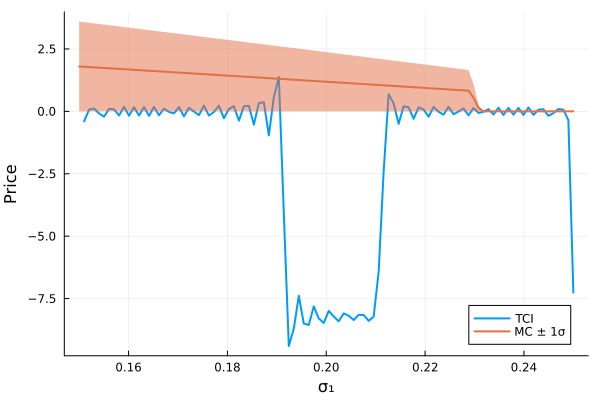

In [380]:
# プロット
using Plots
plot(xvals, tci_vals, label="TCI", xlabel="σ₁", ylabel="Price", lw=2)
plot!(xvals, mc_vals, ribbon=mc_errs, label="MC ± 1σ", lw=2)

# Delta

In [381]:
function delta_MC(T::Float64, r::Float64, K::Float64, d::Int64, vols::Vector{Float64}, stock0::Vector{Float64}, localindex_v, nPath::Int64, corrMat, S0_delta)::Tuple{Float64, Float64}
    vols = [σs[i] for i in localindex_v[1:2:2*d]]
    S0s = [stock0[i] for i in localindex_v[2:2:2*d]]

    S0s_minus = [S0s[1] - S0_delta; S0s[2:end]]  # Subtract delta_vols from the first element
    S0s_plus = [S0s[1] + S0_delta; S0s[2:end]] 

    np.random.seed(seed)  # numpyのシードを固定
    tf.random.set_seed(seed)  # tensorflowのシードを固定

    process = tff.models.MultivariateGeometricBrownianMotion(
        dim=d,
        means=fill(r, d),
        #volatilities=fill(0.2, d),
        volatilities=vols,
        corr_matrix=corrMat)
    paths_minus = process.sample_paths(
        times=[T],
        initial_state=S0s_minus,
        #initial_state=S0,
        seed = seed,
        num_samples=nPath).numpy()

    np.random.seed(seed)  # numpyのシードを固定
    tf.random.set_seed(seed)  # tensorflowのシードを固定
    process = tff.models.MultivariateGeometricBrownianMotion(
        dim=d,
        means=fill(r, d),
        volatilities=vols,
        corr_matrix=corrMat)
    
    paths_plus = process.sample_paths(
        times=[T],
        initial_state=S0s_plus,
        seed = seed,
        num_samples=nPath).numpy()
    
    #diff = ((maximum(paths_plus[:, 1, :], dims=2) .- K, 0.0) .- (maximum(paths_minus[:, 1, :], dims=2) .- K, 0.0)) 
    #diff = (maximum(minimum(paths_plus[:, 1, :], dims=2) .- K, 0.0) .- maximum(minimum(paths_minus[:, 1, :], dims=2) .- K, 0.0))
    payoffs_plus = max.(minimum(paths_plus[:, 1, :], dims=2) .- K, 0.0)
    payoffs_minus = max.(minimum(paths_minus[:, 1, :], dims=2) .- K, 0.0)
    diff = payoffs_plus .- payoffs_minus
    mean_pv = exp(-r * T) * mean(diff) / (2 * S0_delta)
    std_pv = exp(-r * T) * std(diff) / (2 * S0_delta)
    CI = std_pv / sqrt(nPath)
    #pv = exp(-r * T) * mean(max.(minimum(paths[:, 1, :], dims=2) .- K, 0.0))
    return (mean_pv, CI)
    #return pv

end

delta_MC (generic function with 2 methods)

In [382]:
Random.seed!(seed)
d = 5  # 資産数、必要に応じて変更
price_dict_tci_delta = Dict{NTuple{2d,Int}, Float64}()

Random.seed!(1234)
for localindex_v in localindex_v_list
    # [S0_1, σ1, S0_2, σ2, ..., S0_d, σd] のインデックスをランダム生成

    # 各資産ごとに値を取得
    vol_vals = [implied_vol_values_equiv[localindex_v[2i-1]] for i in 1:d]
    s0_vals  = [S0_values_equiv[localindex_v[2i]] for i in 1:d]

    # Chebyshev基底を作成（下記区間は必要に応じてパラメータ化可能）
    weights = Vector{Vector{Float64}}()
    for j in 1:d
        if j == 1
            push!(weights, TCIMC.chebyshev_basis(0.15, 0.25, vol_vals[j], num_nodes))
            push!(weights, TCIMC.chebyshev_basis_derivative(90.0, 120.0, s0_vals[j], num_nodes))
        else
            push!(weights, TCIMC.chebyshev_basis(0.15, 0.25, vol_vals[j], num_nodes))
            push!(weights, TCIMC.chebyshev_basis(90.0, 120.0, s0_vals[j], num_nodes))
        end
    end
    # これでweightsは [σ1, S0_1, σ2, S0_2, ..., σ5, S0_5] の順

    c = 1
    left_cache  = TCIMC.compute_left_cache(C_coeff_tensor_tci, weights, c)
    right_cache = TCIMC.compute_right_cache(C_coeff_tensor_tci, weights, c)
    result_original = TCIMC.update_center(C_coeff_tensor_tci, left_cache, right_cache, weights[c], c)

    price_dict_tci_delta[Tuple(localindex_v)] = result_original
end


# -----------------------------------
# MC による価格評価
# -----------------------------------

price_dict_mc_delta = Dict{NTuple{2d, Int}, Float64}()
price_dict_mc_err_delta = Dict{NTuple{2d, Int}, Float64}()

for localindex_v in localindex_v_list
    mean_pv, std_pv = delta_MC(T, r, K, d, implied_vol_values_equiv, S0_values_equiv , localindex_v, nPath,  corrMat, h_delta)
    price_dict_mc_delta[Tuple(localindex_v)] = mean_pv
    price_dict_mc_err_delta[Tuple(localindex_v)] = std_pv
end



In [383]:
JLD2.@save "err_delta/delta_dict_tci" price_dict_tci_delta
JLD2.@save "err_delta/delta_dict_mc" price_dict_mc_delta
JLD2.@save "err_delta/delta_dict_mc_err" price_dict_mc_err_delta

In [384]:
using Statistics

# 辞書の型を修正
abs_errors_tci = Dict{NTuple{2d,Int},Float64}()
rel_errors_tci = Dict{NTuple{2d,Int},Float64}()
mc_errors      = Dict{NTuple{2d,Int},Float64}()

for key in keys(price_dict_mc_delta)
    # Monte Carlo の結果 (price_dict_mc[key]) と TCI の結果 (price_dict_tci[key]) の差を評価
    mc_val = price_dict_mc_delta[key]
    tci_val = price_dict_tci_delta[key]

    abs_err = abs(mc_val - tci_val)
    rel_err = abs_err / (abs(mc_val) + 1e-12)  # 0除算回避

    abs_errors_tci[key] = abs_err
    rel_errors_tci[key] = rel_err
    mc_errors[key] = price_dict_mc_err_delta[key]
end

# 統計量を計算
abs_error_vals = collect(values(abs_errors_tci))
mc_error_vals  = collect(values(mc_errors))

println("==== TCI  ====")
println("Mean absolute error   : ", mean(abs_error_vals))
println("Max  absolute error   : ", maximum(abs_error_vals))

println("==== MC  ====")
println("Mean MC error         : ", mean(mc_error_vals))
println("Max  MC error         : ", maximum(mc_error_vals))


==== TCI  ====
Mean absolute error   : 0.04145504415621673
Max  absolute error   : 0.16280808018063864
==== MC  ====
Mean MC error         : 0.042142348862871284
Max  MC error         : 0.13702558599094683


In [385]:
# S0_1だけスイープ、他は固定
fixed_indices = [
    rand(1:num_nodes),     # σ1
    # ---- ここからS0_1, σ2, S0_2, σ3 ...の順で交互に並ぶ ----
    # S0_1はスイープするのでここは空けておく
    rand(1:num_nodes),     # σ2
    rand(1:num_nodes_S0),  # S0_2
    rand(1:num_nodes),     # σ3
    rand(1:num_nodes_S0),  # S0_3
    rand(1:num_nodes),     # σ4
    rand(1:num_nodes_S0),  # S0_4
    rand(1:num_nodes),     # σ5
    rand(1:num_nodes_S0)   # S0_5
]
# fixed_indices[1] = σ1
# fixed_indices[2:end] = σ2, S0_2, σ3, S0_3, ..., σ5, S0_5

xvals    = Float64[]
tci_vals = Float64[]
mc_vals  = Float64[]
mc_errs  = Float64[]

for i in 1:num_nodes_S0
    # localindex_vを [σ1, S0_1, σ2, S0_2, ...] の順で作る
    localindex_v = [fixed_indices[1]; i; fixed_indices[2:end]...]
    # [σ1, S0_1, σ2, S0_2, ..., σ5, S0_5] の順

    # 各資産の値取得
    vol_vals = [implied_vol_values_equiv[localindex_v[2j-1]] for j in 1:d]
    s0_vals  = [S0_values_equiv[localindex_v[2j]] for j in 1:d]

    # weights
    weights = Vector{Vector{Float64}}()
    for j in 1:d
        if j == 1
            push!(weights, TCIMC.chebyshev_basis(0.15, 0.25, vol_vals[j], num_nodes))
            push!(weights, TCIMC.chebyshev_basis_derivative(90.0, 120.0, s0_vals[j], num_nodes))
        else
            push!(weights, TCIMC.chebyshev_basis(0.15, 0.25, vol_vals[j], num_nodes))
            push!(weights, TCIMC.chebyshev_basis(90.0, 120.0, s0_vals[j], num_nodes))
        end
    end

    c = 1
    left_cache  = TCIMC.compute_left_cache(C_coeff_tensor_tci, weights, c)
    right_cache = TCIMC.compute_right_cache(C_coeff_tensor_tci, weights, c)
    price = TCIMC.update_center(C_coeff_tensor_tci, left_cache, right_cache, weights[c], c)

    push!(tci_vals, price)

    # --- MCによる価格 ---
    mean_mc, std_mc = delta_MC(T, r, K, d, implied_vol_values_equiv, S0_values_equiv , localindex_v, nPath,  corrMat, h_delta)
    push!(mc_vals, mean_mc)
    push!(mc_errs, std_mc)

    # x軸（S0_1の値）
    push!(xvals, S0_values_equiv[i])
end


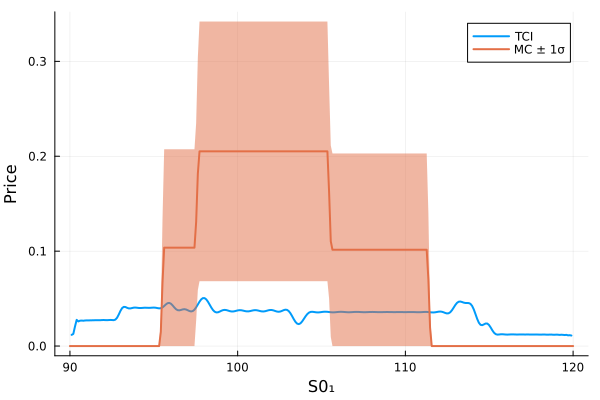

In [386]:
using Plots
plot(xvals, tci_vals, label="TCI", xlabel="S0₁", ylabel="Price", lw=2)
plot!(xvals, mc_vals, ribbon=mc_errs, label="MC ± 1σ", lw=2)

# Gamma

In [389]:
function gamma_MC(T::Float64, r::Float64, K::Float64, d::Int64, vols::Vector{Float64}, stock0::Vector{Float64},  localindex_v, nPath::Int64,  corrMat, S0_delta)::Tuple{Float64, Float64}
    vols = [σs[i] for i in localindex_v[1:2:2*d]]
    S0s = [stock0[i] for i in localindex_v[2:2:2*d]]

    S0s_minus = [S0s[1] - S0_delta; S0s[2:end]]  # Subtract delta_vols from the first element
    S0s_plus = [S0s[1] + S0_delta; S0s[2:end]] 

    np.random.seed(seed)  # numpyのシードを固定
    tf.random.set_seed(seed)  # tensorflowのシードを固定
    process = tff.models.MultivariateGeometricBrownianMotion(
        dim=d,
        means=fill(r, d),
        #volatilities=fill(0.2, d),
        volatilities=vols,
        corr_matrix=corrMat)
    paths_minus = process.sample_paths(
        times=[T],
        initial_state=S0s_minus,
        #initial_state=S0,
        seed = seed,
        num_samples=nPath).numpy()

    np.random.seed(seed)  # numpyのシードを固定
    tf.random.set_seed(seed)  # tensorflowのシードを固定
    process = tff.models.MultivariateGeometricBrownianMotion(
        dim=d,
        means=fill(r, d),
        volatilities=vols,
        corr_matrix=corrMat)
    
    paths_plus = process.sample_paths(
        times=[T],
        initial_state=S0s_plus,
        seed = seed,
        num_samples=nPath).numpy()
    
    np.random.seed(seed)  # numpyのシードを固定
    tf.random.set_seed(seed)  # tensorflowのシードを固定
    process = tff.models.MultivariateGeometricBrownianMotion(
        dim=d,
        means=fill(r, d),
        volatilities=vols,
        corr_matrix=corrMat)
    
    paths = process.sample_paths(
        times=[T],
        initial_state=S0s,
        seed = seed,
        num_samples=nPath).numpy()
    
    #diff = ((maximum(paths_plus[:, 1, :], dims=2) .- K, 0.0) .- (maximum(paths_minus[:, 1, :], dims=2) .- K, 0.0)) 
    #diff = (maximum(minimum(paths_plus[:, 1, :], dims=2) .- K, 0.0) .- maximum(minimum(paths_minus[:, 1, :], dims=2) .- K, 0.0))
    payoffs_plus = max.(minimum(paths_plus[:, 1, :], dims=2) .- K, 0.0)
    payoffs_minus = max.(minimum(paths_minus[:, 1, :], dims=2) .- K, 0.0)
    payoffs = max.(minimum(paths[:, 1, :], dims=2) .- K, 0.0)
    diff = payoffs_plus .- 2.0 .* payoffs .+ payoffs_minus
    
    mean_pv = exp(-r * T) * mean(diff) / (S0_delta^2)
    std_pv = exp(-r * T) * std(diff) / (S0_delta^2)
    CI = std_pv / sqrt(nPath)
    #pv = exp(-r * T) * mean(max.(minimum(paths[:, 1, :], dims=2) .- K, 0.0))
    return (mean_pv, CI)
    #return pv

end

gamma_MC (generic function with 2 methods)

In [392]:
Random.seed!(seed)
d = 5  # 資産数、必要に応じて変更
price_dict_tci_gamma = Dict{NTuple{2d,Int}, Float64}()

Random.seed!(1234)
for localindex_v in localindex_v_list
    # [S0_1, σ1, S0_2, σ2, ..., S0_d, σd] のインデックスをランダム生成

    # 各資産ごとに値を取得
    vol_vals = [implied_vol_values_equiv[localindex_v[2i-1]] for i in 1:d]
    s0_vals  = [S0_values_equiv[localindex_v[2i]] for i in 1:d]

    # Chebyshev基底を作成（下記区間は必要に応じてパラメータ化可能）
    weights = Vector{Vector{Float64}}()
    for j in 1:d
        if j == 1
            push!(weights, TCIMC.chebyshev_basis(0.15, 0.25, vol_vals[j], num_nodes))
            push!(weights, TCIMC.chebyshev_basis_second_derivative(90.0, 120.0, s0_vals[j], num_nodes))
        else
            push!(weights, TCIMC.chebyshev_basis(0.15, 0.25, vol_vals[j], num_nodes))
            push!(weights, TCIMC.chebyshev_basis(90.0, 120.0, s0_vals[j], num_nodes))
        end
    end
    # これでweightsは [σ1, S0_1, σ2, S0_2, ..., σ5, S0_5] の順

    c = 1
    left_cache  = TCIMC.compute_left_cache(C_coeff_tensor_tci, weights, c)
    right_cache = TCIMC.compute_right_cache(C_coeff_tensor_tci, weights, c)
    result_original = TCIMC.update_center(C_coeff_tensor_tci, left_cache, right_cache, weights[c], c)

    price_dict_tci_gamma[Tuple(localindex_v)] = result_original
end


# -----------------------------------
# MC による価格評価
# -----------------------------------

price_dict_mc_gamma = Dict{NTuple{2d, Int}, Float64}()
price_dict_mc_err_gamma = Dict{NTuple{2d, Int}, Float64}()

for localindex_v in localindex_v_list
    mean_pv, std_pv = gamma_MC(T, r, K, d, implied_vol_values_equiv, S0_values_equiv , localindex_v, nPath,  corrMat, h_delta)
    price_dict_mc_gamma[Tuple(localindex_v)] = mean_pv
    price_dict_mc_err_gamma[Tuple(localindex_v)] = std_pv
end

In [394]:
JLD2.@save "err_gamma/gamma_dict_tci" price_dict_tci_gamma
JLD2.@save "err_gamma/gamma_dict_mc" price_dict_mc_gamma
JLD2.@save "err_gamma/gamma_dict_mc_err" price_dict_mc_err_gamma

In [395]:
using Statistics

# 辞書の型を修正
abs_errors_tci = Dict{NTuple{2d,Int},Float64}()
rel_errors_tci = Dict{NTuple{2d,Int},Float64}()
mc_errors      = Dict{NTuple{2d,Int},Float64}()

for key in keys(price_dict_mc_gamma)
    # Monte Carlo の結果 (price_dict_mc[key]) と TCI の結果 (price_dict_tci[key]) の差を評価
    mc_val = price_dict_mc_gamma[key]
    tci_val = price_dict_tci_gamma[key]

    abs_err = abs(mc_val - tci_val)
    rel_err = abs_err / (abs(mc_val) + 1e-12)  # 0除算回避

    abs_errors_tci[key] = abs_err
    rel_errors_tci[key] = rel_err
    mc_errors[key] = price_dict_mc_err_gamma[key]
end

# 統計量を計算
abs_error_vals = collect(values(abs_errors_tci))
mc_error_vals  = collect(values(mc_errors))

println("==== TCI  ====")
println("Mean absolute error   : ", mean(abs_error_vals))
println("Max  absolute error   : ", maximum(abs_error_vals))

println("==== MC  ====")
println("Mean MC error         : ", mean(mc_error_vals))
println("Max  MC error         : ", maximum(mc_error_vals))


==== TCI  ====
Mean absolute error   : 0.02113041308984159
Max  absolute error   : 0.6392852634487725
==== MC  ====
Mean MC error         : 0.012489899711119587
Max  MC error         : 0.6369430875659747


In [397]:
# S0_1だけスイープ、他は固定
fixed_indices = [
    rand(1:num_nodes),     # σ1
    # ---- ここからS0_1, σ2, S0_2, σ3 ...の順で交互に並ぶ ----
    # S0_1はスイープするのでここは空けておく
    rand(1:num_nodes),     # σ2
    rand(1:num_nodes_S0),  # S0_2
    rand(1:num_nodes),     # σ3
    rand(1:num_nodes_S0),  # S0_3
    rand(1:num_nodes),     # σ4
    rand(1:num_nodes_S0),  # S0_4
    rand(1:num_nodes),     # σ5
    rand(1:num_nodes_S0)   # S0_5
]
# fixed_indices[1] = σ1
# fixed_indices[2:end] = σ2, S0_2, σ3, S0_3, ..., σ5, S0_5

xvals    = Float64[]
tci_vals = Float64[]
mc_vals  = Float64[]
mc_errs  = Float64[]

for i in 1:num_nodes_S0
    # localindex_vを [σ1, S0_1, σ2, S0_2, ...] の順で作る
    localindex_v = [fixed_indices[1]; i; fixed_indices[2:end]...]
    # [σ1, S0_1, σ2, S0_2, ..., σ5, S0_5] の順

    # 各資産の値取得
    vol_vals = [implied_vol_values_equiv[localindex_v[2j-1]] for j in 1:d]
    s0_vals  = [S0_values_equiv[localindex_v[2j]] for j in 1:d]

    # weights
    weights = Vector{Vector{Float64}}()
    for j in 1:d
        if j == 1
            push!(weights, TCIMC.chebyshev_basis(0.15, 0.25, vol_vals[j], num_nodes))
            push!(weights, TCIMC.chebyshev_basis_second_derivative(90.0, 120.0, s0_vals[j], num_nodes))
        else
            push!(weights, TCIMC.chebyshev_basis(0.15, 0.25, vol_vals[j], num_nodes))
            push!(weights, TCIMC.chebyshev_basis(90.0, 120.0, s0_vals[j], num_nodes))
        end
    end

    c = 1
    left_cache  = TCIMC.compute_left_cache(C_coeff_tensor_tci, weights, c)
    right_cache = TCIMC.compute_right_cache(C_coeff_tensor_tci, weights, c)
    price = TCIMC.update_center(C_coeff_tensor_tci, left_cache, right_cache, weights[c], c)

    push!(tci_vals, price)

    # --- MCによる価格 ---
    mean_mc, std_mc = gamma_MC(T, r, K, d, implied_vol_values_equiv, S0_values_equiv , localindex_v, nPath,  corrMat, h_delta)
    push!(mc_vals, mean_mc)
    push!(mc_errs, std_mc)

    # x軸（S0_1の値）
    push!(xvals, S0_values_equiv[i])
end


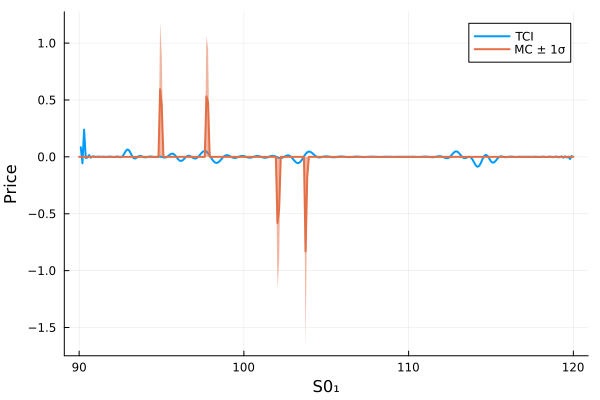

In [398]:
using Plots
plot(xvals, tci_vals, label="TCI", xlabel="S0₁", ylabel="Price", lw=2)
plot!(xvals, mc_vals, ribbon=mc_errs, label="MC ± 1σ", lw=2)